# Organic matter decomposition kinetics in cranberry agroecosystems 

*Wilfried Dossou-Yovo, Serge Étienne Parent,Noura Ziadi, Élizabeth Parent and Léon Étienne Parent*

In [1]:
print(Sys.Date())

[1] "2020-06-09"


## Objective

This notebook generates the results included in the manuscript *Tea bag index (TBI) and decomposition kinetics in cranberry agroecosystems*. The data set from 2017 trial is a collection of incubated tea bag weight, nitrogen, carbon and sulfur content, nitrogen type and doses on trials fieds. The aims of this study were to measure the TBI and kinetics of plant residue decomposition to estimate soil sequestration capacity in cranberry stands of Eastern Canada.

## Packages

We need package [tidyverse](https://www.tidyverse.org/) which loads a set of packages for easy data manipulation(Ex: [dplyr](https://www.rdocumentation.org/packages/dplyr/versions/0.7.8)) and visualization (ex: [ggplot2](https://www.rdocumentation.org/packages/ggplot2/versions/3.2.1)). A set of other packages is used: [nlme](https://www.rdocumentation.org/packages/nlme/versions/3.1-143/topics/nlme) for fitting a nonlinear mixed-effects model, [e1071](https://www.rdocumentation.org/packages/e1071/versions/1.7-3) for latent class analysis, [ggmap](https://www.rdocumentation.org/packages/ggmap/versions/3.0.0) for mapping, [ggrepel](https://www.rdocumentation.org/packages/ggrepel/versions/0.8.1) that provides text and label geoms for 'ggplot2' and [cowplot](https://www.rdocumentation.org/packages/cowplot/versions/1.0.0) that provides various features that help with creating publication-quality figures with 'ggplot2', [composition](https://www.rdocumentation.org/packages/compositions/versions/1.40-5) for compositional data analysis and [patchwork](https://www.rdocumentation.org/packages/patchwork/versions/1.0.0/topics/patchwork-package) is a package that expands the API to allow for arbitrarily complex composition of plots by, among others, providing mathematical operators for combining multiple plots.

In [2]:
library("tidyverse")
library("nlme")
library("e1071")
library("ggmap")
library("ggrepel")
library("cowplot")
library("compositions")
library("patchwork")

Warning message:
"package 'tidyverse' was built under R version 3.6.2"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.2.1     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
Warning message:
"package 'ggplot2' was built under R version 3.6.2"Warning message:
"package 'tibble' was built under R version 3.6.2"Warning message:
"package 'tidyr' was built under R version 3.6.2"Warning message:
"package 'readr' was built under R version 3.6.2"Warning message:
"package 'purrr' was built under R version 3.6.2"Warning message:
"package 'dplyr' was built under R version 3.6.2"Warning message:
"package 'stringr' was built under R version 3.6.2"Warning message:
"package 'forcats' was built under R version 3.6.2"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning mess

### Map design : Experimental site study

We design a map of our four experimental sites with geographical position collected from google earth.

Source : http://tile.stamen.com/toner-lite/4/4/4.png
Source : http://tile.stamen.com/toner-lite/4/5/4.png
Source : http://tile.stamen.com/toner-lite/4/4/5.png
Source : http://tile.stamen.com/toner-lite/4/5/5.png
Source : http://tile.stamen.com/toner-lite/8/76/90.png
Source : http://tile.stamen.com/toner-lite/8/77/90.png
Source : http://tile.stamen.com/toner-lite/8/76/91.png
Source : http://tile.stamen.com/toner-lite/8/77/91.png
Warning message:
"package 'patchwork' was built under R version 3.6.3"
Attaching package: 'patchwork'

The following object is masked from 'package:cowplot':

    align_plots

Warning message in min(x):
"aucun argument trouvé pour min ; Inf est renvoyé"Warning message in max(x):
"aucun argument pour max ; -Inf est renvoyé"Warning message in min(x):
"aucun argument trouvé pour min ; Inf est renvoyé"Warning message in max(x):
"aucun argument pour max ; -Inf est renvoyé"Warning message in min(x):
"aucun argument trouvé pour min ; Inf est renvoyé"Warning message in 

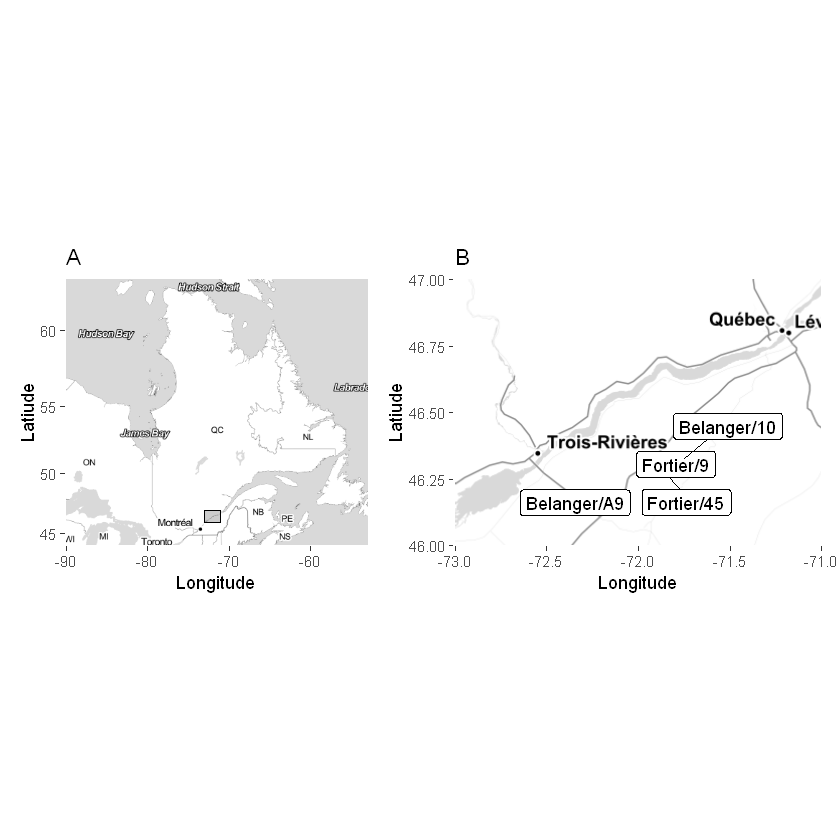

In [3]:
sites <- tibble(sites = c("", "", "", ""),
                lat = c(46.2759555, 46.2759555, 46.2329064, 46.3277404),
                lon = c(-71.8584291, -71.8584291, -72.0461854, -71.7486645))
site <- tibble(sites = c("Fortier/45", "Fortier/9", "Belanger/A9", "Belanger/10"),
                lat = c(46.2759555, 46.2759555, 46.2329064, 46.3277404),
                lon = c(-71.8584291, -71.8584291, -72.0461854, -71.7486645))

frame_map_zoom_out <- c(left = -90, bottom = 44, right = -53, top = 63)
frame_map_zoom_in <- c(left = -73, bottom = 46, right = -71, top = 47)

rect_zoom <- data.frame(t(data.frame(frame_map_zoom_in)))
frame_map_zoom_out <- c(left = -90, bottom = 44, right = -53, top = 63)
frame_map_zoom_in <- c(left = -73, bottom = 46, right = -71, top = 47)

map_out <- get_stamenmap(frame_map_zoom_out, zoom = 4, maptype = "toner-lite") %>%
  ggmap() +
  geom_rect(data = rect_zoom, aes(xmin = left, xmax = right,
                                  ymin = bottom, ymax = top,
                                  x = NULL, y = NULL),
            fill = rgb(0, 0, 0, 0.2), colour = "black") +
  geom_label_repel(data = sites, aes(x = lon, y = lat, label = sites)) +
  labs(x = "Longitude", y = "Latiude", title = "A")

map_in <- get_stamenmap(frame_map_zoom_in, zoom = 8, maptype = "toner-lite") %>%
  ggmap() +
  geom_label_repel(data = site, aes(x = lon, y = lat, label = sites)) +
  labs(x = "Longitude", y = "Latiude", title = "B")

library("patchwork")
map_out + map_in

ggsave("figures/site_map.png", width = 8, height = 6, dpi = 600)


## Some custom functions.
### Pseudo R-square
Pseudo R-square allows to measure how well variables of our model explain organic matter decomposition

In [4]:
pseudoR2 <- function(y, y_hat) {
  1 - (sum((y - y_hat)^2) / sum((y - mean(y))^2))
}

# Residuals
residues <- function(model, level = 0, computeResidues = TRUE, residues,
                   main = "") {
  if (computeResidues) {
    r = residuals(model, type="normalized", level)
  } else {
    r = residues
  }
  hist(r, freq=F, main = main, breaks=20)
  xfit<-seq(min(r),max(r),length=40)
  yfit<-dnorm(xfit)
  lines(xfit, yfit, col="red", lwd=2)
  print("Shapiro-Wilk:")
  print(shapiro.test(r))
  print(paste("Kurtosis:", kurtosis(r)))
  print(paste("Skewness:", skewness(r)))
}


## Import data
Here, we load our data `data.csv` available for the project in the `data` folder.

In [5]:
df <- read_csv("data/data.csv")

Parsed with column specification:
cols(
  No = col_double(),
  `Tea type abbr` = col_character(),
  `Tea type` = col_character(),
  `Initial tea weight (g)` = col_double(),
  `Initial total weight (g)` = col_double(),
  `Initial bag weight (g)` = col_double(),
  `Remaining tea weight (g)` = col_double(),
  Farm = col_character(),
  Site = col_character(),
  `Farming system` = col_character(),
  `Nitrogen type` = col_character(),
  `Nitrogen dose` = col_double(),
  Repetition = col_double(),
  `Remaining C (%)` = col_double(),
  `Remaining N (%)` = col_double(),
  `Remaining S (%)` = col_double(),
  `Initial C fraction` = col_double()
)


Label repetitions in such a way they are unique per field and dose

In [6]:
df$`Dose repetition` = paste0(df$`Nitrogen dose`, '_', df$Repetition,'_', df$Site)

*Cranberry litter* category will be used for the reference category in modeling.

In [7]:
df$`Tea type` = relevel(factor(df$`Tea type`), ref = 'Cranberry litter')

## Preprocess : weight loss rate

Weight loss rate has been estimate by

$$k_1 = \frac{-ln \left( \frac{M(t)}{M_0} \right) }{t}$$

Where $M_0$ is initial litter organic mass, $M(t)$ is litter organic mass that remains after incubation time $t = 90~days$, and $k_1$ is decomposition rate. 

In [8]:
kinetics_1st <- function(rw, iw, t) {
    -log(rw/iw)/t
}

In [9]:
df$k1 <- kinetics_1st(rw = df$`Remaining tea weight (g)`,
                      iw = df$`Initial tea weight (g)`,
                      t = 90)

## Data exploration

In [10]:
head(df)

No,Tea type abbr,Tea type,Initial tea weight (g),Initial total weight (g),Initial bag weight (g),Remaining tea weight (g),Farm,Site,Farming system,Nitrogen type,Nitrogen dose,Repetition,Remaining C (%),Remaining N (%),Remaining S (%),Initial C fraction,Dose repetition,k1
1,G,Green tea,1.793,2.019,0.226,0.783,Belanger,A9,Organic,N-8-0-0,0,1,50.144,5.2809,0.290,0.8605444,0_1_A9,0.009205698
2,G,Green tea,1.786,2.011,0.225,0.797,Belanger,A9,Organic,N-8-0-0,0,1,50.933,4.4082,0.251,0.8571847,0_1_A9,0.008965323
3,G,Green tea,1.782,2.008,0.228,NA,Belanger,A9,Organic,N-8-0-0,0,1,NA,NA,NA,0.8552650,0_1_A9,NA
4,G,Green tea,1.760,1.987,0.227,0.778,Belanger,A9,Organic,N-8-0-0,0,2,50.292,5.4397,0.296,0.8447061,0_2_A9,0.009070473
5,G,Green tea,1.788,2.013,0.226,0.779,Belanger,A9,Organic,N-8-0-0,0,2,47.718,4.8735,0.277,0.8581446,0_2_A9,0.009231577
6,G,Green tea,1.779,2.004,0.227,NA,Belanger,A9,Organic,N-8-0-0,0,2,NA,NA,NA,0.8538251,0_2_A9,NA


Boxplot

Warning message:
"Removed 49 rows containing non-finite values (stat_boxplot)."

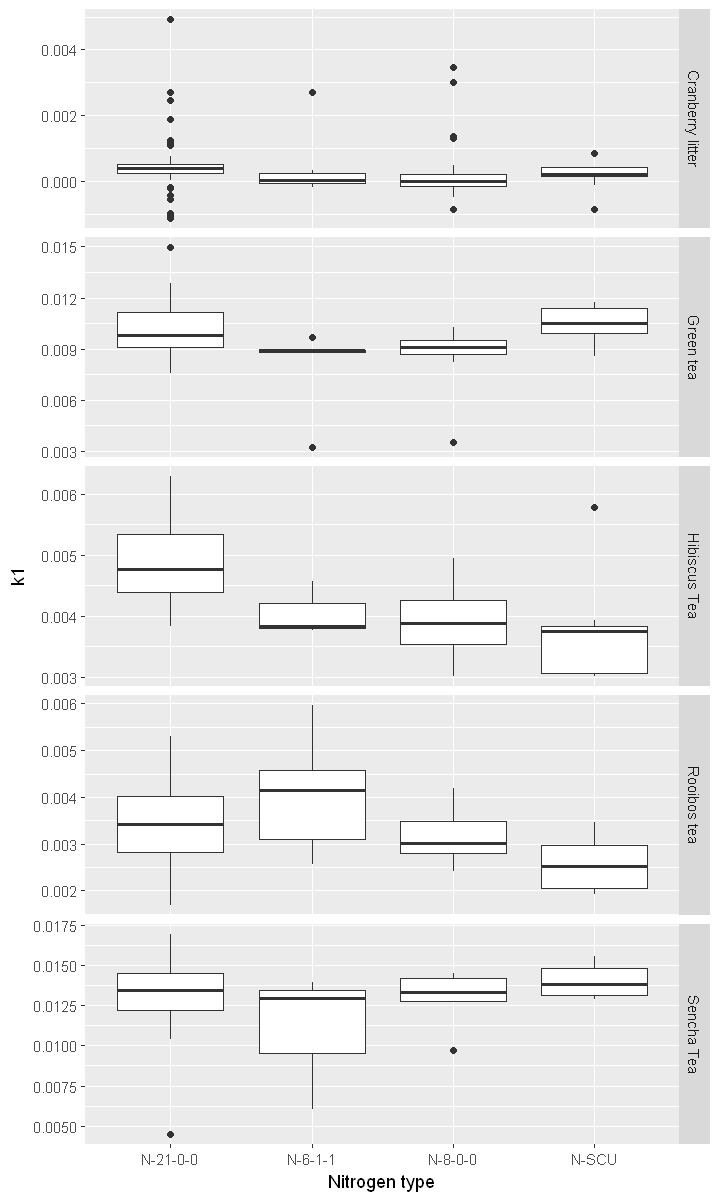

In [11]:
options(repr.plot.width = 6, repr.plot.height = 10)
ggplot(data = df,
       mapping = aes(x = `Nitrogen type`, y = k1)) +
  facet_grid(`Tea type` ~ ., scales = "free") +
  geom_boxplot()

## What's affecting litters weight?

### Mixed model

In [12]:
df <- df %>%
  mutate(`Nitrogen dose scaled` = scale(`Nitrogen dose`))

In [13]:
df_mm <- df %>%
  rename(tea = `Tea type`,
         Ntype = `Nitrogen type`,
         Ndose = `Nitrogen dose scaled`) %>%
  mutate(tea = factor(tea),
         Ntype = factor(Ntype)) %>%
  drop_na() %>%
  droplevels()

In [14]:
k1_mm <- lme(fixed = k1 ~ Ntype + Ndose * tea,
                     random = ~ 1 | Farm/Site,
                     data = df_mm)

In [15]:
anova(k1_mm)

,numDF,denDF,F-value,p-value
(Intercept),1,346,90.4235185,0.000000e+00
Ntype,3,346,9.2425070,6.769315e-06
Ndose,1,346,0.4951898,4.820946e-01
tea,4,346,1309.7307309,0.000000e+00
Ndose:tea,4,346,2.4427939,4.649410e-02


### Pseudo r-square
Pseudo r-square was high with(0.94) and without(0.91) random effect indicated the influence of random effects was not impotant. Moreover, pseudo r-square was high, indicated mixed model was well fit to data.   

In [16]:
pseudoR2(y = df_mm$k1,
         y_hat = predict(k1_mm, level = 0))

pseudoR2(y = df_mm$k1,
         y_hat = predict(k1_mm, level = 2))

[1] 0.9179982

[1] 0.9405054

### Shapiro-Wilk normality test

[1] "Shapiro-Wilk:"

	Shapiro-Wilk normality test

data:  r
W = 0.93463, p-value = 1.636e-11

[1] "Kurtosis: 4.72506311595992"
[1] "Skewness: 0.0203648806888307"


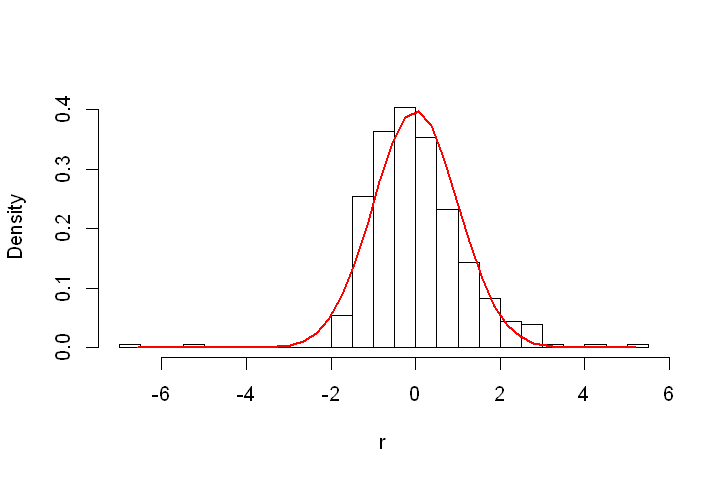

In [17]:
options(repr.plot.width = 6, repr.plot.height = 4)
residues(k1_mm)

## Mixed model

In [18]:
k1_gg <- data.frame(intervals(k1_mm, which = "fixed")$fixed)
k1_gg <- k1_gg %>%
  mutate(variable = rownames(k1_gg))
k1_gg <- k1_gg %>%
  mutate(pvalue = summary(k1_mm)$tTable[, 5],
         is_significant = ifelse(pvalue <= 0.05, 'Significant at 0.05 level', 'Not significant at 0.05 level'))

k1_gg$variable <- c("Intercept", "N 6-1-1", "N 8-0-0", "N SCU-39-0-0", # Ajust names
                    "Dose N (scaled)", "Green tea", "Hibiscus tea", "Rooibos tea", "Sencha tea",
                     "Green tea : Dose N", "Hibiscus tea : Dose N", "Rooibos tea : Dose N", "Sencha tea : Dose N")

Adding random effects to the table.

In [19]:
k1_re <- data.frame(matrix(ncol = ncol(k1_gg), nrow = 6))
names(k1_re) <- names(k1_gg)
k1_re$est. <- c(ranef(k1_mm)$Farm[, 1], ranef(k1_mm)$Site[, 1])
k1_re$variable <- c(rownames(ranef(k1_mm)$Farm),
                    rownames(ranef(k1_mm)$Site))

if (!("Belanger" %in% k1_gg$variable)) k1_gg <- bind_rows(k1_gg, k1_re) # with an if to make sure ranefs are stacked only once

Create a facet column to separate effects by effect category in the plot.

In [20]:
k1_gg$facet <- factor(c('Intercept',
                        'N source', 'N source', 'N source',
                        "N dosage",
                        'Tea type', 'Tea type', 'Tea type', 'Tea type',
                        'Tea type x N dosage', 'Tea type x N dosage', 
                        'Tea type x N dosage', 'Tea type x N dosage',
                        "Random effect", "Random effect", "Random effect", "Random effect", "Random effect", "Random effect"))

k1_gg <- k1_gg %>%
  mutate(facet = factor(facet, levels = rev(c("Random effect", "Tea type x N dosage", "Tea type", "N dosage", "N source"))))

### Mixed model showing factors that impacted organic matter decomposition rate (k1), using cranberry litter as reference (95% confident interval).

Warning message:
"Removed 6 rows containing missing values (geom_segment)."Warning message:
"Removed 6 rows containing missing values (geom_segment)."

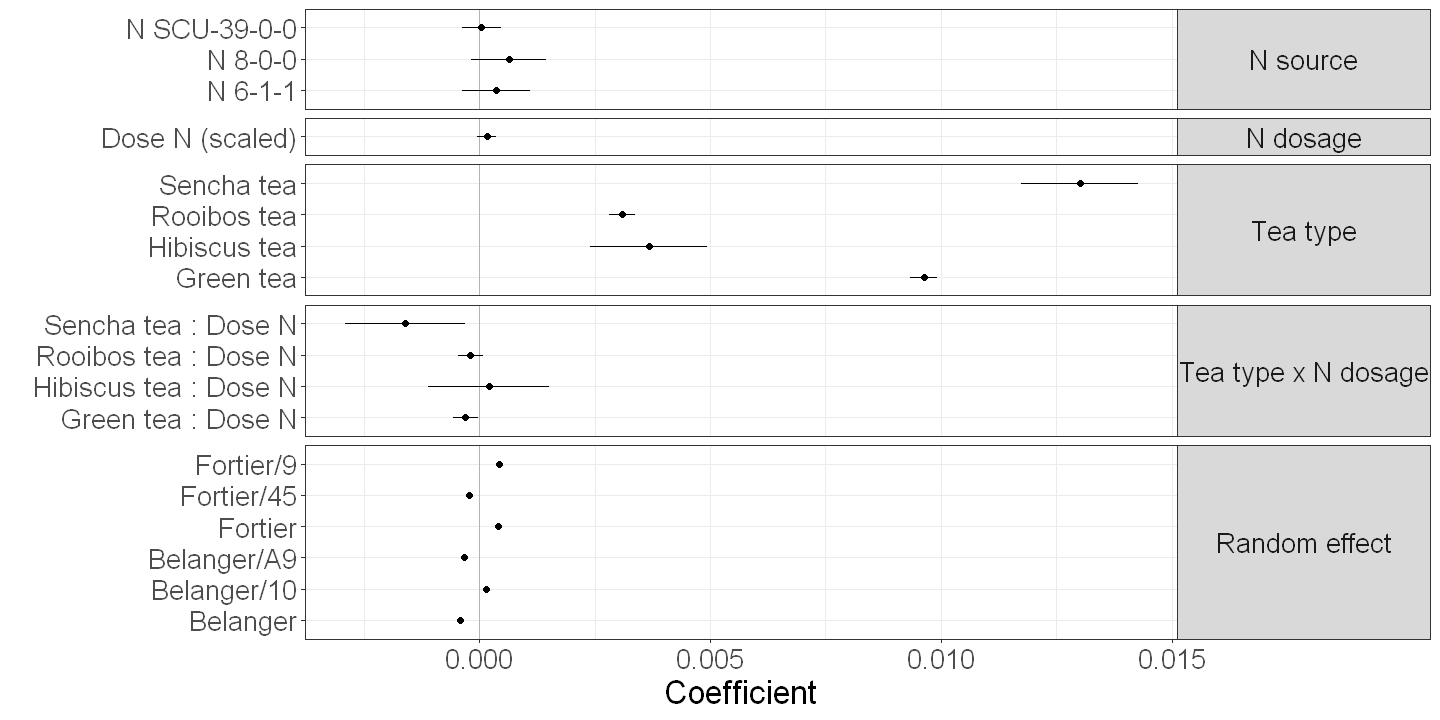

In [21]:
options(repr.plot.width = 12, repr.plot.height = 6)
k1_gg %>%
  filter(variable != "Intercept") %>%
  ggplot(aes(x = est., y = variable)) +
  facet_grid(facet ~ ., scales = 'free', space = 'free') +
  geom_vline(xintercept = 0, colour='grey70') +
  geom_point() +
  geom_segment(aes(x = lower, xend = upper, y = variable, yend = variable)) +
  xlab('Coefficient') +
  ylab('') +
  theme_bw() +
  theme(strip.text.y = element_text(angle=0),
        legend.title = element_blank(),
        legend.position = "bottom",
        text = element_text(size = 20)) +
  ggsave("figures/Figure2.png", width = 8, height = 6, dpi = 600)

### Effect of N dosage on organic matter decomposition rate (k1)

In [22]:
pred_grid <- expand.grid(tea = unique(df_mm$tea),
                                     Ndose = c(-2, 2),
                                     Ntype = unique(df_mm$Ntype))
pred_grid <- pred_grid %>%
  mutate(k1 = predict(k1_mm, newdata = pred_grid,
                              level = 0),
         Ndose = Ndose * sd(df$`Nitrogen dose`) + mean(df$`Nitrogen dose`)) %>%
  rename(`Tea type` = tea,
         `Nitrogen dose` = Ndose,
         `Nitrogen type` = Ntype)

### Effect of N dosage on organic matter decomposition rate (k1).

Warning message:
"Removed 49 rows containing missing values (geom_point)."Warning message:
"Removed 49 rows containing missing values (geom_point)."

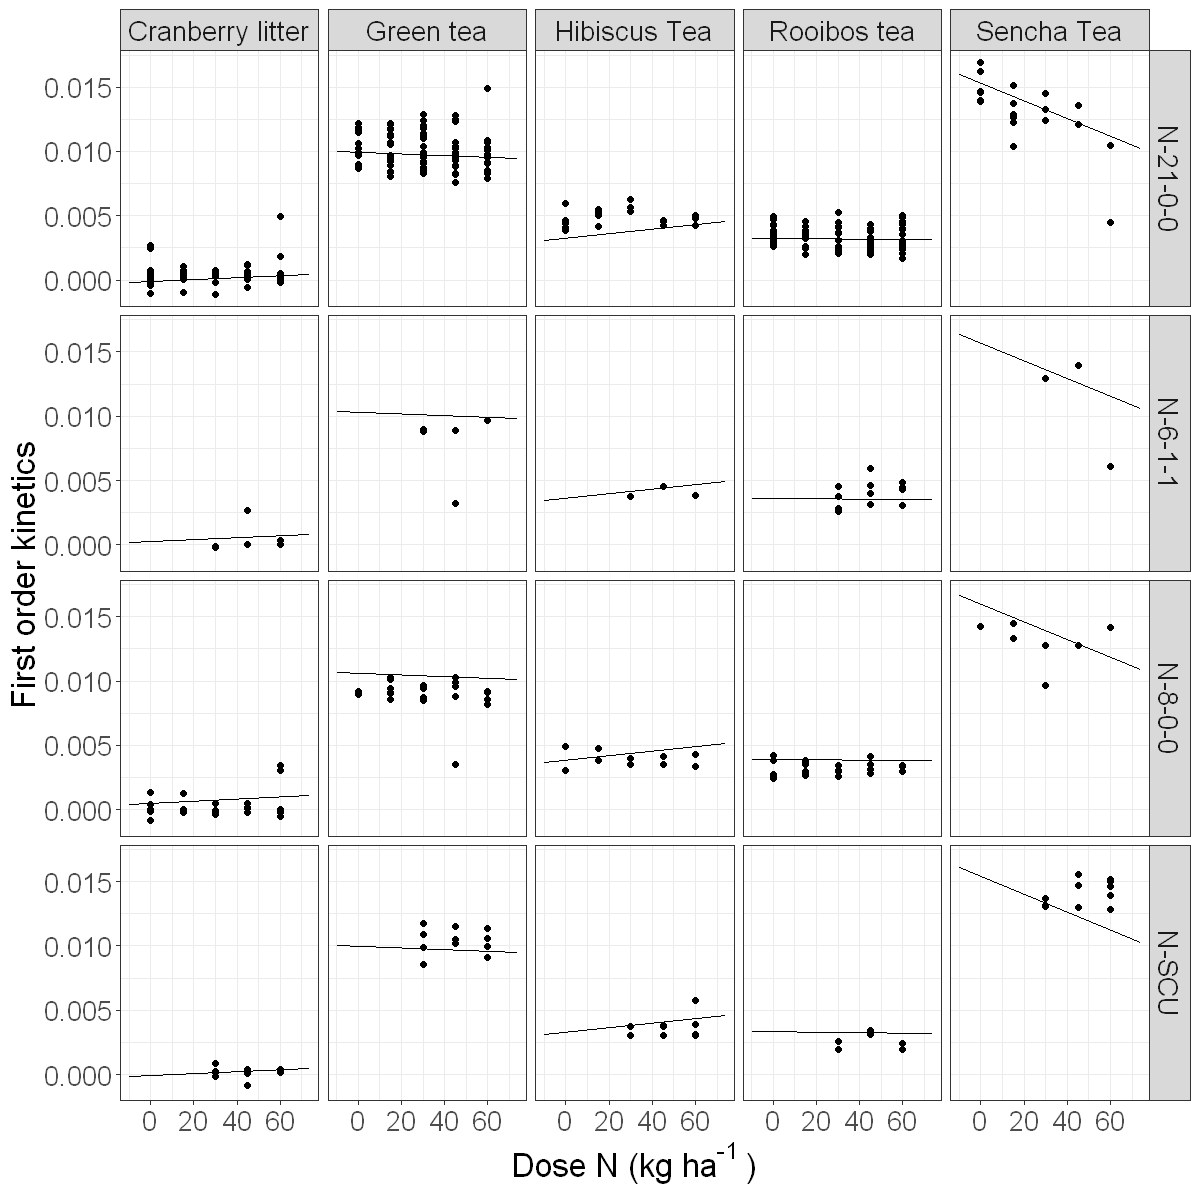

In [23]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(df, aes(x = `Nitrogen dose`, y = `k1`)) +
  facet_grid(`Nitrogen type` ~ `Tea type`) +
  geom_point() +
  geom_line(data = pred_grid) +
  labs(x = expression("Dose N (kg ha"^"-1"~")"), y = "First order kinetics") +
  theme_bw() +
  theme(text = element_text(size = 20)) + 
  ggsave("figures/k1-model-lines.png", width = 10, height = 6, dpi = 600)# nomme figure

## Tea bag index

Adding `M / M0` variable to data `df`

In [24]:
df <- df %>%
  mutate(`M / M0` = `Remaining tea weight (g)` / `Initial tea weight (g)`)

In [129]:
data_fractal <- read_csv2("data/data_fractal.csv")
df2 <- subset(data_fractal, Prelevement <= 4 ) %>%
            rename(`Remaining tea weight (g)` = `Final weight (g)`,
                  `Initial tea weight (g)` = `Initial weight (g)`)

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.
Parsed with column specification:
cols(
  `Tea type` = col_character(),
  Prelevement = col_double(),
  `Final carbon (%)` = col_double(),
  `Final weight (g)` = col_double(),
  `Initial weight (g)` = col_double(),
  `Initial carbon (%)` = col_double()
)


[1] "Tea type"           "Prelevement"        "Final carbon (%)"  
[4] "Final weight (g)"   "Initial weight (g)" "Initial carbon (%)"

In [113]:
df2 <- df2 %>%
  mutate(`M / M0` = `Remaining tea weight (g)` / `Initial tea weight (g)`)

Hydrolysable fraction 

In [114]:
Hf_g = 0.805   # Hydrolysable fraction for Green tea
Hf_r = 0.826   # Hydrolysable fraction for Rooibos tea

For comparaison purpose, we brought Keuskamp et al.(2013) Hydrolysable fraction.  
Keuskamp Hydrolysable fraction for Green tea `Hf_g = 0.842`  
Keuskamp Hydrolysable fraction for Rooibos tea `Hf_r = 0.552`

### Computation of labile fraction (a) and stabilization factor (s) of green tea
The key point to understand about TBI is that decomposition rate `k_tbi` is computed from Rooibos tea as for 90 days incubation time. TBI suppose that Green tea decomposition is over whereas Rooibos tea still decomposing. Stabilization factor `S` is computed from Green tea.

In [121]:
df <- df %>%
  mutate(a = ifelse(`Tea type` == "Green tea",
                    (`Initial tea weight (g)` - `Remaining tea weight (g)`) / `Initial tea weight (g)`,
                    NA),
         S = 1 - a / Hf_g)

Compute litter stability `Sg` (Green tea) and decomposition constant `k_tbi` (Rooibos) for each experimental unit.

In [122]:
df <- df %>%
  mutate(sdr = paste(df$Site, df$`Nitrogen dose`, df$Repetition))
sdr_u <- unique(df$sdr)

In [123]:
for (i in 1:length(sdr_u)) {
  # Green tea
  Sg_i <- mean(df$S[df$sdr == sdr_u[i] & df$`Tea type` == "Green tea"], na.rm = TRUE)
  
  # Rooibos
  df$a[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"] <- Hf_r * (1 - Sg_i)
  ar_i <- df$a[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"]
  M_M0i <- df$`M / M0`[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"]
  df$k_tbi[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"] <- log(ar_i / (M_M0i - (1-ar_i))) / 90
}

Data exploration for N dose type.

Warning message:
"Removed 388 rows containing non-finite values (stat_boxplot)."

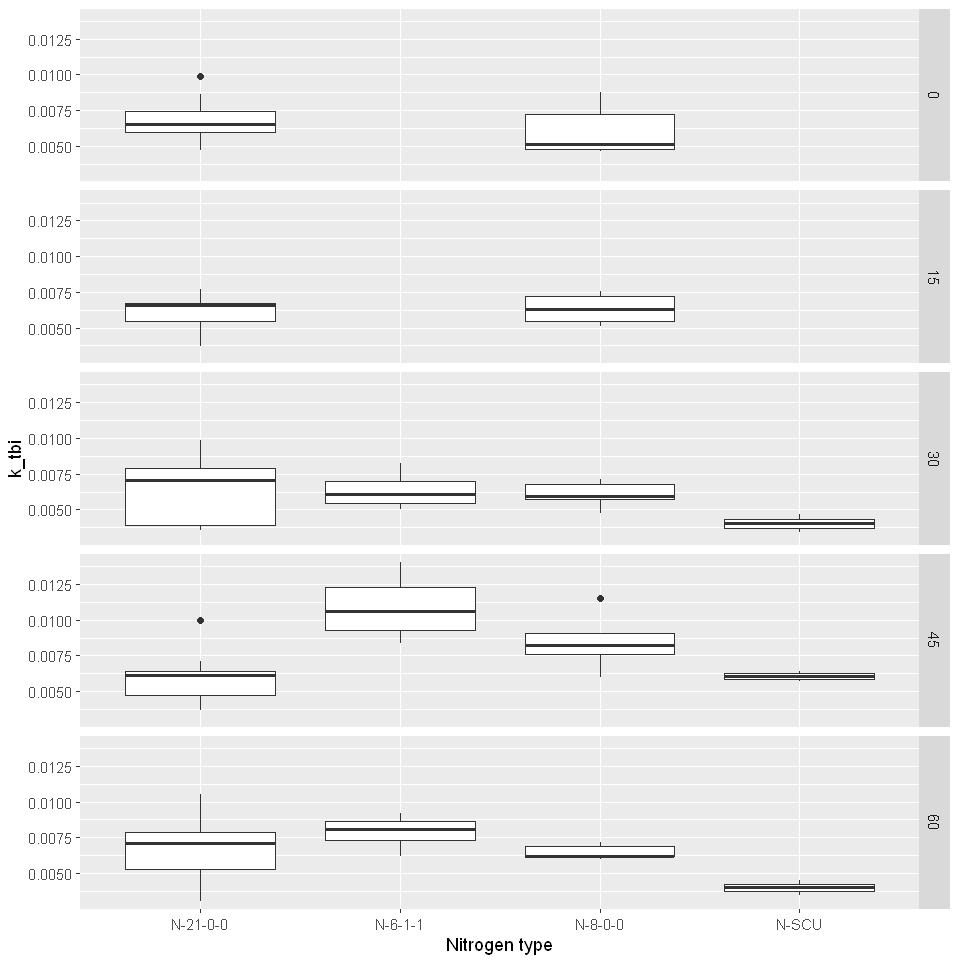

In [125]:
options(repr.plot.width=8, repr.plot.height=8)
ggplot(data = df,
       mapping = aes(x = `Nitrogen type`, y = k_tbi)) +
  facet_grid(`Nitrogen dose` ~ .) +
  geom_boxplot()

### What affecting TBI parameters (k)?
As underline above, `k_tbi` is computed from Rooibos tea. Then, first we substract Rooibos data named `df_rooibos` 

In [30]:
df_rooibos <- df %>% 
  filter(`Tea type` == "Rooibos tea")

TBI_data <- df %>%
  select(k_tbi, `Tea type`, Farm, `Nitrogen dose`, Site,
         `Nitrogen type`) %>%
  rename(Ntype = `Nitrogen type`,
         Ndose = `Nitrogen dose`) %>%
  drop_na() %>%
  droplevels()

In [31]:
TBI_rooibos <- TBI_data %>%
  filter(`Tea type` == "Rooibos tea")

### `k_tbi` mixed model

In [32]:
lme_TBI <- lme(fixed = k_tbi ~  Ndose + Ntype,
    random = ~ 1 | Farm/Site,
    data = TBI_rooibos)

In [33]:
pred_grid_tbi <- expand.grid(Ndose = c(0, 60),
                             Ntype = unique(df_mm$Ntype))
pred_grid_tbi <- pred_grid_tbi %>%
  mutate(k_tbi = predict(lme_TBI, newdata = pred_grid_tbi,
                              level = 0)) %>%
  rename(`Nitrogen dose` = Ndose,
         `Nitrogen type` = Ntype)

### Effect of N dosage on k_tbi.

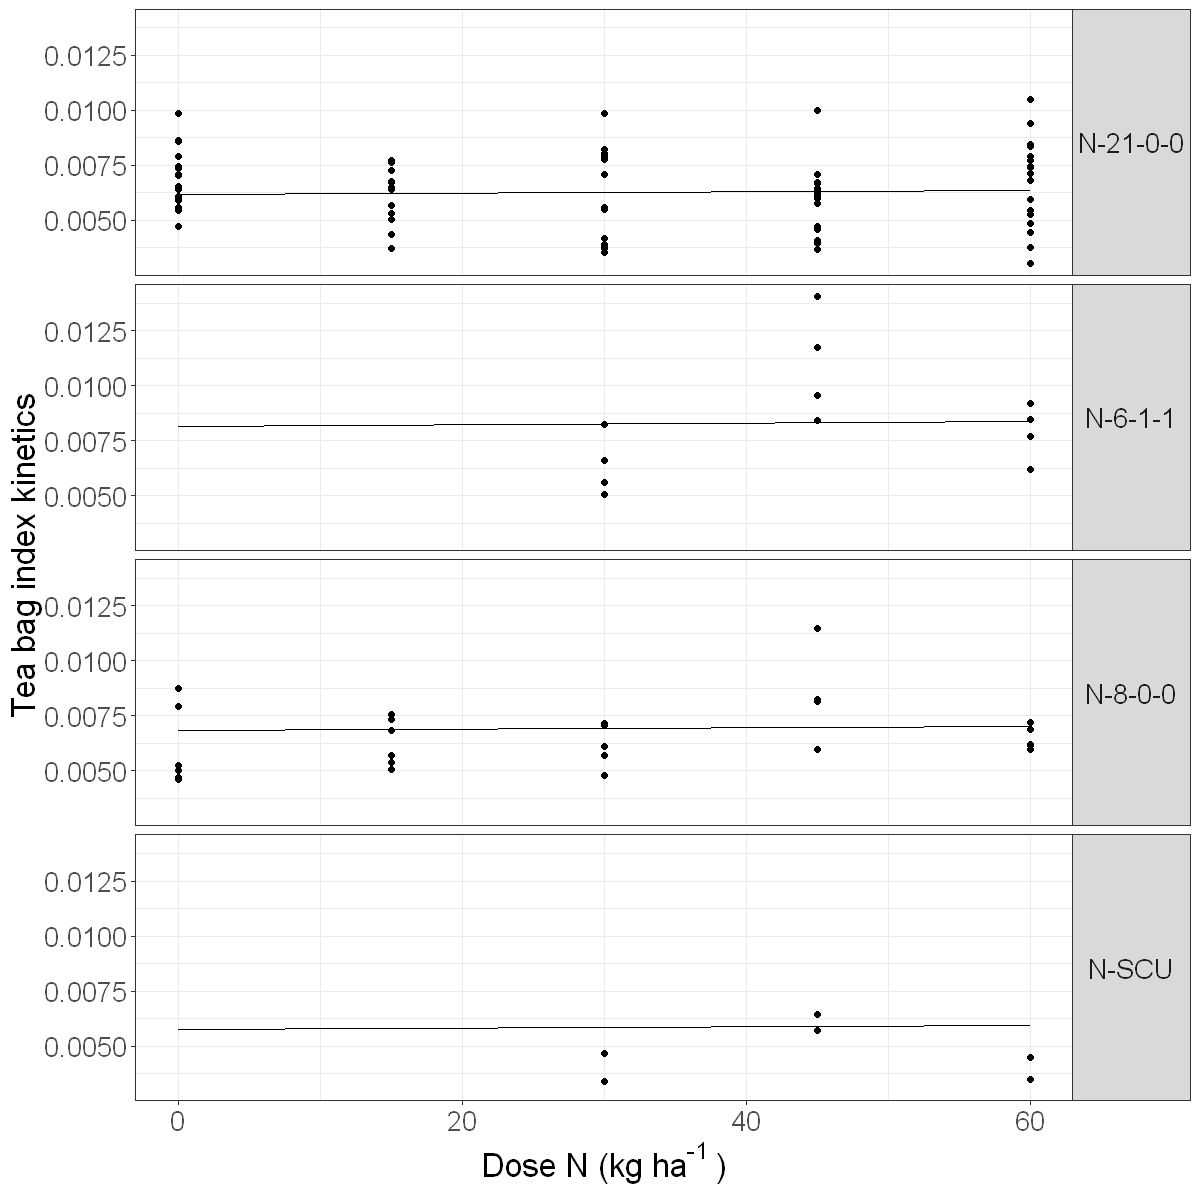

In [34]:
options(repr.plot.width=10, repr.plot.height=10)

TBI_rooibos %>% 
  rename(`Nitrogen dose` = Ndose,
         `Nitrogen type` = Ntype) %>%
  ggplot(aes(x = `Nitrogen dose`, y = k_tbi)) +
  facet_grid(`Nitrogen type` ~ .) +
  geom_point() +
  geom_line(data = pred_grid_tbi) +
  labs(x = expression("Dose N (kg ha"^"-1"~")"), y = "Tea bag index kinetics") +
  theme_bw() +
  theme(text = element_text(size = 20),
        strip.text.y = element_text(angle=0)) +
  ggsave("figures/tbi-model-lines.png", width = 10, height = 6, dpi = 600)

### Mixed model

In [35]:
ktbi_gg <- data.frame(intervals(lme_TBI, which = "fixed")$fixed)
ktbi_gg <- ktbi_gg %>%
  mutate(variable = rownames(ktbi_gg))
ktbi_gg <- ktbi_gg %>%
  mutate(pvalue = summary(lme_TBI)$tTable[, 5],
         is_significant = ifelse(pvalue <= 0.05, 'Significant at 0.05 level', 'Not significant at 0.05 level'))

Ajust names.

In [36]:
ktbi_gg$variable <- c("Intercept", "Dose N", "N 6-1-1", "N 8-0-0", "N SCU-39-0-0")

Add random effects to the table.

In [37]:
ktbi_re <- data.frame(matrix(ncol = ncol(ktbi_gg), nrow = 6))
names(ktbi_re) <- names(ktbi_gg)
ktbi_re$est. <- c(ranef(lme_TBI)$Farm[, 1], ranef(lme_TBI)$Site[, 1])
ktbi_re$variable <- c(rownames(ranef(lme_TBI)$Farm),
                    rownames(ranef(lme_TBI)$Site))

In [38]:
if (!("Belanger" %in% ktbi_gg$variable)) ktbi_gg <- bind_rows(ktbi_gg, ktbi_re) # with an if to make sure ranefs are stacked only once

Create a facet column to separate effects by effect category in the plot.

In [39]:
ktbi_gg$facet <- factor(c('Intercept',
                        "N dosage",
                        'N source', 'N source', 'N source',
                        "Random effect", "Random effect", "Random effect", "Random effect", "Random effect", "Random effect"))

In [40]:
ktbi_gg <- ktbi_gg %>%
  mutate(facet = factor(facet, levels = rev(c("Random effect", "N dosage", "N source", "Intercept"))))

Warning message:
"Removed 6 rows containing missing values (geom_segment)."Warning message:
"Removed 6 rows containing missing values (geom_segment)."

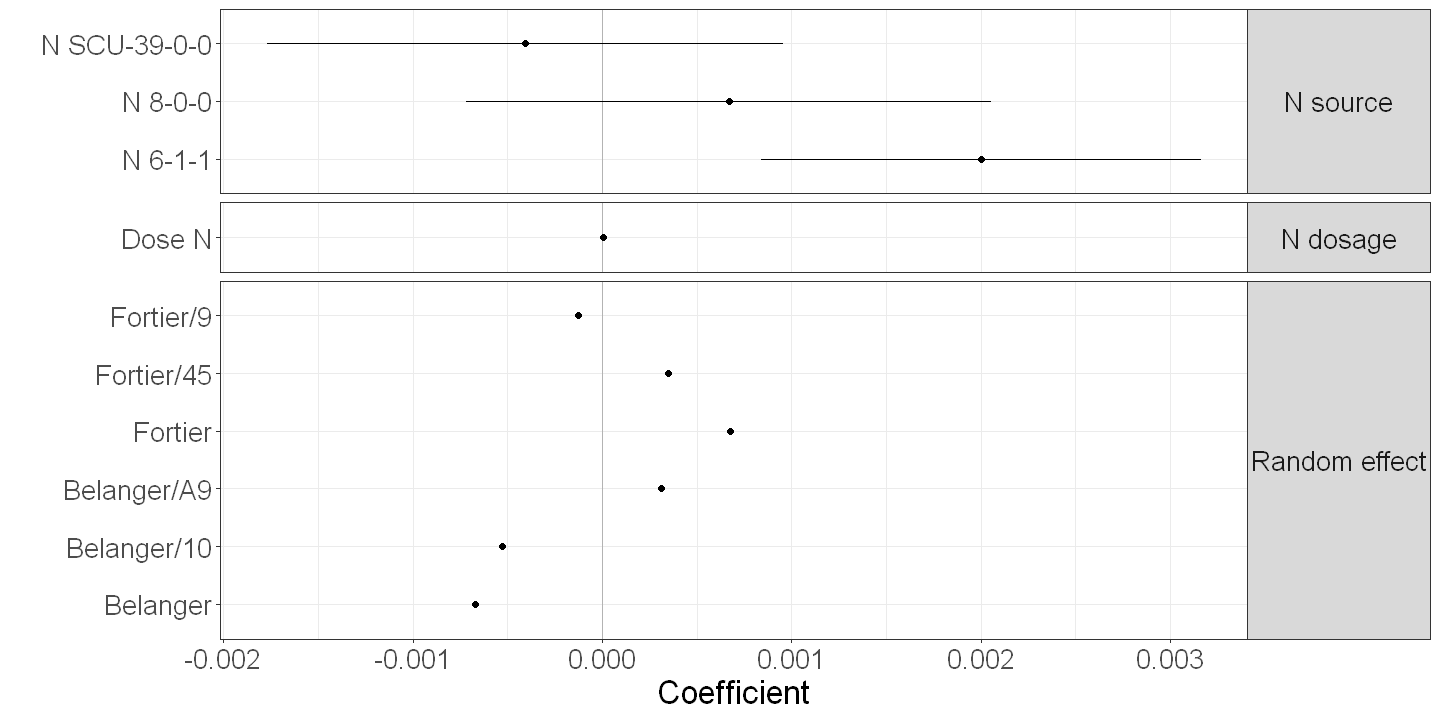

In [41]:
options(repr.plot.width = 12, repr.plot.height = 6)

ktbi_gg %>%
  filter(variable != "Intercept") %>%
  ggplot(aes(x = est., y = variable)) +
  facet_grid(facet ~ ., scales = 'free', space = 'free') +
  geom_vline(xintercept = 0, colour='grey70') +
  geom_point() +
  geom_segment(aes(x = lower, xend = upper, y = variable, yend = variable)) +
  xlab('Coefficient') +
  ylab('') +
  theme_bw() +
  theme(strip.text.y = element_text(angle=0),
        legend.title = element_blank(),
        legend.position = "bottom",
        text = element_text(size = 20)) +
  ggsave("figures/ktbi-lme-effects.png", width = 8, height = 5, dpi = 600)

## Litters biochemical composition balance

### Import data

In [42]:
data_fiber <- read_csv('data/data_fiber_initial.csv')

Parsed with column specification:
cols(
  `Biomass type` = col_character(),
  `SOL perc initial (%)` = col_double(),
  `HOLO perc initial (%)` = col_double(),
  `LIC perc initial (%)` = col_double()
)


### Isometic log ratio (Ilr)

In [43]:
TeaCompositionSBP <- matrix(c(-1, 1,1,
                              0, 1, -1),
                           byrow = TRUE,
                           ncol = 3)
colnames(TeaCompositionSBP) <- c('Lignine', 'Soluble', 'Holocelulose')
TeaCompositionComp <- acomp(data_fiber %>%
                      select(`LIC perc initial (%)`, `SOL perc initial (%)`,  `HOLO perc initial (%)`))
TeaCompositionBal <- ilr(TeaCompositionComp, V = gsi.buildilrBase(t(TeaCompositionSBP)))
data_fiber$TeaComposition_L.HS <- TeaCompositionBal[, 1] # ilr1 [Lignin | Soluble.Holocelulose]
data_fiber$TeaComposition_S.H <- TeaCompositionBal[, 2] # ilr2 [Soluble | Holocelulose]

### Plot of classification of litters using balances among biochemical components

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


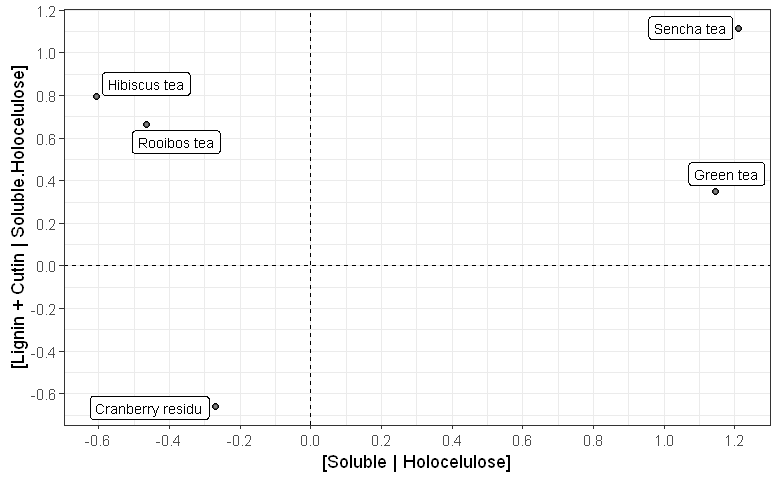

In [44]:
options(repr.plot.width = 6.5, repr.plot.height = 4)
ggplot(data_fiber, aes(x =  `TeaComposition_S.H`, y = `TeaComposition_L.HS`)) +
geom_point()+
geom_label_repel(aes(label = `Biomass type`), size = 3) +
labs(x = "[Soluble | Holocelulose]" , y = "[Lignin + Cutin | Soluble.Holocelulose]") +
theme(axis.title.x = element_text(size = 14), axis.title.y = element_text(size = 14)) +
xlim(-1.5, 1.5) +
scale_y_continuous(breaks=seq(-2,2,0.2)) + 
scale_x_continuous(breaks=seq(-2,2,0.2)) +
geom_hline(yintercept = 0, linetype = "dashed") +
geom_vline(xintercept = 0, linetype = "dashed") +
theme_bw() +
geom_point(size = 1, alpha = 0.5, pch = 21, fill = "white") 
ggsave("figures/Classification of litters using balances among biochemical components.png", width = 6, height = 4, dpi = 120)

## Reproducing Keuskamp's TBI
We adapted keuskamp's TBI by adding cranberry ecosystem

### Import data

In [230]:
df_keuskamp <- read_csv("data/keuskamp_tbi_data.csv")# Import Keuskamp data

Parsed with column specification:
cols(
  Nombre = col_double(),
  Region = col_character(),
  Stabilisation_factor_S = col_double(),
  Decomposition_rate_K = col_double()
)


In [231]:
df_keuskamp <- df_keuskamp %>%
  mutate(is_cranberry = Region == "Cranberries")

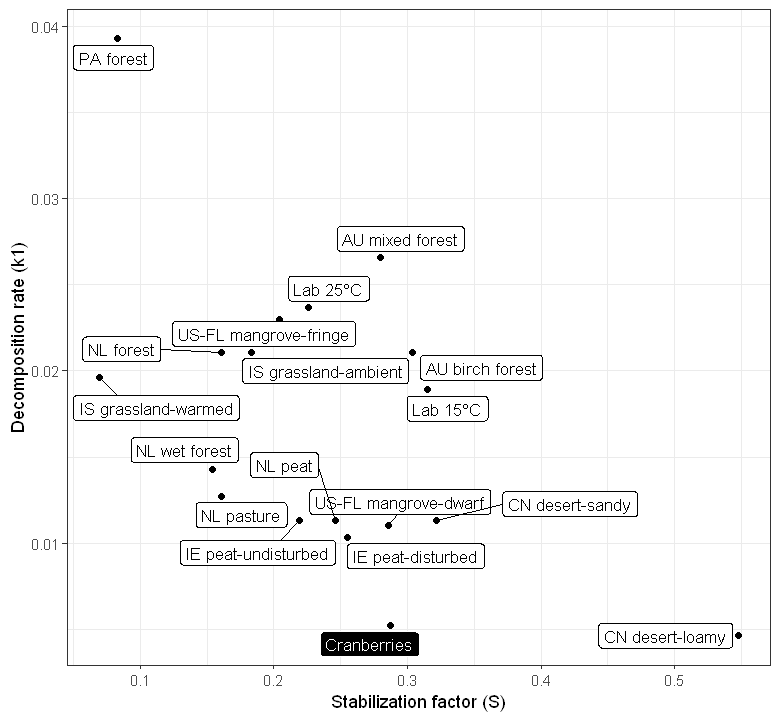

In [232]:
options(repr.plot.width = 6.5, repr.plot.height = 6)
ggplot(data = df_keuskamp, aes(x = Stabilisation_factor_S, y = Decomposition_rate_K)) +
  geom_point() +
  geom_label_repel(aes(label = Region, fill = is_cranberry, colour = is_cranberry),
                   size = 3.5) +
  scale_fill_manual(values = c("white", "black")) +
  scale_colour_manual(values = c("black", "white")) +
  theme_bw() +
  theme(legend.position = "none") +
  labs(x = "Stabilization factor (S)", y = "Decomposition rate (k1)") +
  ggsave("figures/TBI_keuskamp.png", width = 6, height = 6, dpi = 120)

## Fractal kinetic

Depending on the nature of decaying material and its immediate environment, the decomposition rate of plant residues can decrease gradually through time as follow: 
$$K(t) = k_1 t^{{-h}}$$

Where $k_1$ is reaction rate at time t = 1 and $h$ is a fractal coefficient (0 ≤ h ≤ 1) accounting for the decreasing decomposition rate through time

### Import data

In [81]:
data_fractal <- read_csv2("data/data_fractal.csv")

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.
Parsed with column specification:
cols(
  `Tea type` = col_character(),
  Prelevement = col_double(),
  `Final carbon (%)` = col_double(),
  `Final weight (g)` = col_double(),
  `Initial weight (g)` = col_double(),
  `Initial carbon (%)` = col_double()
)


### Adding some variables
`Initial carbon (g)`, `Final carbon (g)` and `Log ratio` has been computed 

In [49]:
names(data_fractal)

[1] "Tea type"           "Prelevement"        "Final carbon (%)"  
[4] "Final weight (g)"   "Initial weight (g)" "Initial carbon (%)"

In [50]:
data_fractal <- data_fractal %>%
mutate(`Initial carbon (g)` = `Initial weight (g)` * `Initial carbon (%)` / 100,
       `Final carbon (g)` = `Final weight (g)` * `Final carbon (%)` / 100,
      `Log ratio` = - log(`Final carbon (g)`/`Initial carbon (g)`))
     

### Fractal kinetic ranged from 0 to 1. It's has been determined by trying value from `(0; 0.1; 0.2 ....1)` and choosing the one with maximum R square

## Rooibos tea fractal kinetic `H_Rooibos = 0.2`

In [51]:
H_Rooibos = 0.2
P_Rooibos = 1- H_Rooibos

data_rooibos <- subset(data_fractal, `Tea type` == "Rooibos tea")

data_rooibos <- data_rooibos %>%
                mutate(Time = (Prelevement * 21) ** P_Rooibos)%>%
                select(Prelevement, Time, `Log ratio`, `Tea type`)%>%
                rename(Log = `Log ratio`, `Tea.type` = 'Tea type')

data_rooibos <- rbind(data_rooibos, data.frame("Log" = 0, "Time" = 0, "Prelevement" = 0,
                                              "Tea.type" = "Rooibos tea")) 

data_median_rooibos <- aggregate(cbind(Time, Log) ~ Prelevement + Tea.type, data = data_rooibos, FUN = median)

Slope = coef(lm(`Log` ~ `Time`, data_median_rooibos))[2]
Intercept = coef(lm(`Log` ~ `Time`, data_median_rooibos))[1]
R.squared = summary(lm(Log ~ Time, data_median_rooibos))$r.squared
R.squared
Slope
Intercept


[1] 0.943643

Time 
0.007341073

(Intercept) 
-0.02102096

## Cranberry residue fractal kinetic `H_Cranberry = 0`

In [52]:
H_Cranberry = 0
P_Cranberry = 1- H_Cranberry

data_cranberry <- subset(data_fractal, `Tea type` == "Cranberry litter")

data_cranberry <- data_cranberry %>%
                mutate(Time = (Prelevement * 21) ** P_Cranberry)%>%
                select(Prelevement, Time, `Log ratio`, `Tea type`)%>%
                rename(Log = `Log ratio`, `Tea.type` = 'Tea type')

data_cranberry <- rbind(data_cranberry, data.frame("Log" = 0, "Time" = 0, "Prelevement" = 0,
                                                  "Tea.type" = "Cranberry litter")) 

data_median_cranberry <- aggregate(cbind(Time, Log) ~ Prelevement + Tea.type, data = data_cranberry, FUN = median)

Slope = coef(lm(`Log`~ `Time`, data_median_cranberry))[2]
Intercept = coef(lm(`Log`~ `Time`, data_median_cranberry))[1]
R.squared = summary(lm(Log ~ Time, data_median_cranberry))$r.squared
R.squared
Slope
Intercept

[1] 0.8040357

Time 
0.001684889

(Intercept) 
-0.07568761

## Green tea fractal kinetic `H_Green = 0.7`

In [53]:
H_Green = 0.7
P_Green = 1- H_Green

data_green <- subset(data_fractal, `Tea type` == "Green tea")

data_green <- data_green %>%
                mutate(Time = (Prelevement * 21) ** P_Green)%>%
                select(Prelevement, Time, `Log ratio`, `Tea type`)%>%
                rename(Log = `Log ratio`, `Tea.type` = 'Tea type')

data_green <- rbind(data_green, data.frame("Prelevement" = 0,"Time" = 0, 
                                           "Log" = 0, "Tea.type" = "Green tea")) 

data_median_green <- aggregate(cbind(Time, Log) ~ Prelevement + Tea.type  , data = data_green, FUN = median)

Slope = coef(lm(`Log` ~ `Time`, data_median_green))[2]
Intercept = coef(lm(`Log` ~ `Time`, data_median_green))[1]
R.squared = summary(lm(Log ~ Time, data_median_green))$r.squared
R.squared
Slope
Intercept

[1] 0.9796549

Time 
0.1910798

(Intercept) 
-0.01336714

### Fractal kinetics of green tea, rooibos tea and cranberry litter decomposition under field conditions

In [54]:
data_fractal <- rbind(data_median_green, data_median_rooibos, data_median_cranberry)

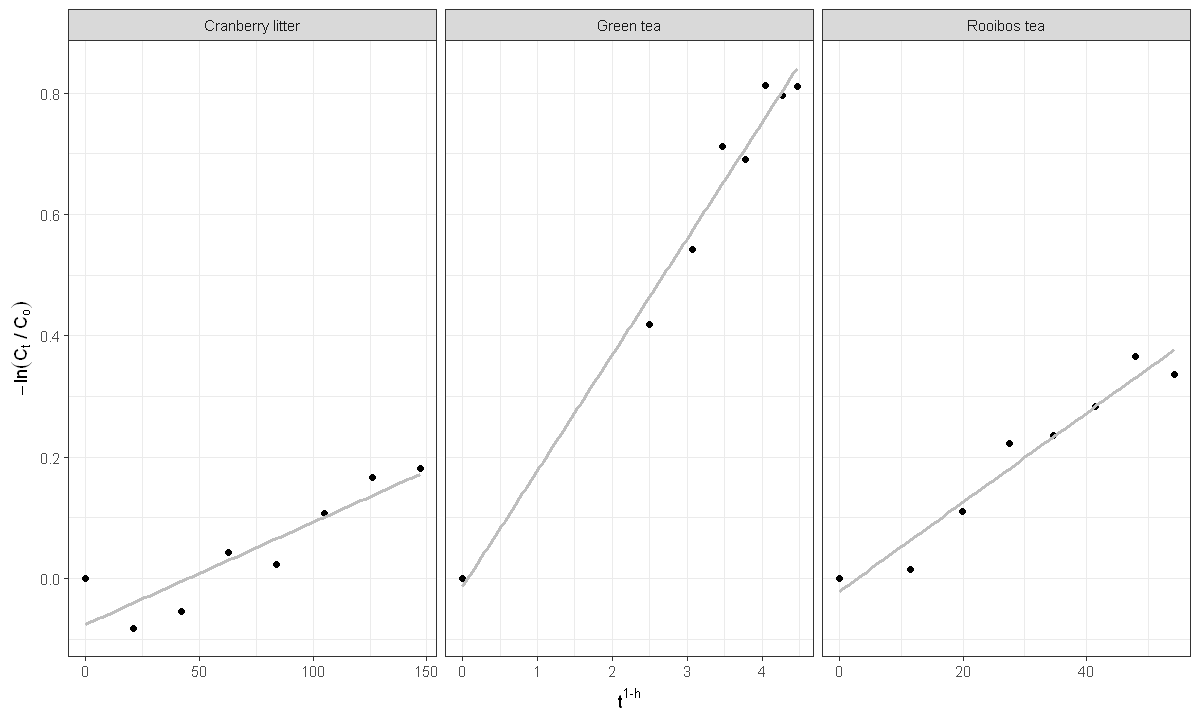

In [55]:
options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(data_fractal, aes(x = `Time`, y = `Log`, group = Tea.type)) +
labs(x = expression("t"^"1-h"), y = expression(-ln(C[t]~"/"~C[o]))) +
facet_grid( .~ Tea.type, scales = 'free') +
theme(axis.title.x = element_text(size = 14), 
  axis.title.y = element_text(size = 14)) +
theme_bw() +
  geom_point() +
  geom_smooth(method = "lm",color = 'grey', se = FALSE) +
ggsave("figures/Fractal kinetic.png", width = 6, height = 4, dpi = 120)

In [56]:
Slope = coef(lm(`Log` ~ `Time`, data_fractal))[2]
Intercept = coef(lm(`Log` ~ `Time`, data_fractal))[1]
R.squared = summary(lm(Log ~ Time, data_fractal))$r.squared
R.squared
Slope
Intercept
summary(lm(Log ~ Time, data_fractal))

[1] 0.1119908

Time 
-0.002357499

(Intercept) 
   0.364268


Call:
lm(formula = Log ~ Time, data = data_fractal)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.39705 -0.23492  0.00385  0.16872  0.45764 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.364268   0.077122   4.723 0.000103 ***
Time        -0.002357   0.001415  -1.666 0.109953    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.287 on 22 degrees of freedom
Multiple R-squared:  0.112,	Adjusted R-squared:  0.07163 
F-statistic: 2.775 on 1 and 22 DF,  p-value: 0.11


## Estimation of the carbon decreasing rate of teas and cranberry residue

### Reaction rate $k_1$ at time t = 1
$k_1$ is the slope of the regresssion lines

In [57]:
K1_rooibos = 0.007 
K1_green = 0.19
K1_cranberry = 0.002

### Litter decomposition rate K depends on time
$$K(t) = k_1 t^{{-h}}$$

In [70]:
data_rate <- data.frame(Prelevement = 1:7)%>%
                            mutate(`Time (days)` = `Prelevement` * 21,
                                  `Rate cranberry` = K1_cranberry *  `Time (days)`**-H_Cranberry,
                                  `Rate rooibos` = K1_rooibos * `Time (days)`**-H_Rooibos,
                                  `Rate green` = K1_green * `Time (days)`**-H_Green) %>%
                            rename(`Cranberry litter` = `Rate cranberry`,
                                  `Rooibos tea` = `Rate rooibos`,
                                   `Green tea` = `Rate green`)

### Tranforming data_rate into long format data in order to generate the plot

In [71]:
data_long <- gather(data = data_rate, key = `tea type`, value = Rate, c(`Cranberry litter`, `Rooibos tea`, `Green tea`),
                    factor_key=TRUE)
data_long <- data_long %>%
             rename(`Litter type`= `tea type`)   

### Plot of litter decomposition rate over time under field conditions

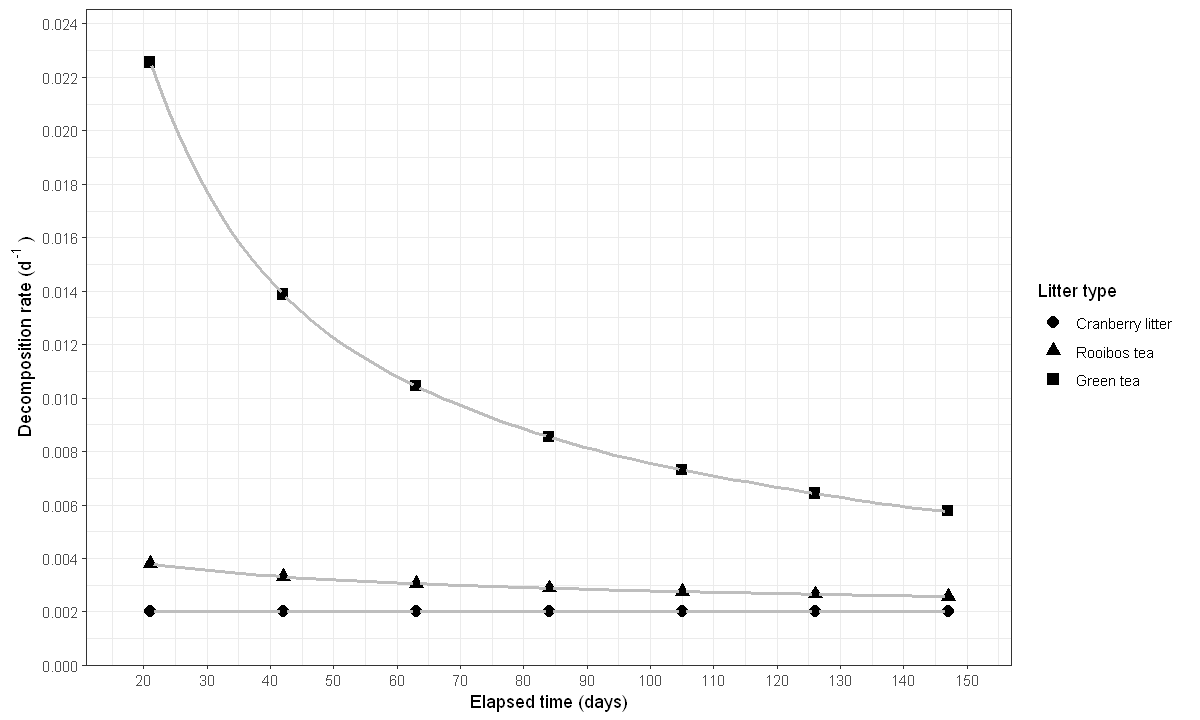

In [75]:
options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(data_long, aes(x = `Time (days)`, y = `Rate`, group = `Litter type`)) +
geom_point(aes(shape = `Litter type`), size = 3)+
geom_smooth(method = "lm", formula = y ~ poly(x, 6) , color = 'grey', se = FALSE) + 
labs(x = "Elapsed time (days)" , y = expression("Decomposition rate (d"^" -1"~")"))  +
theme(axis.title.x = element_text(size = 14), 
  axis.title.y = element_text(size = 14),
     legend.text=element_text(size=14)) +
scale_y_continuous(breaks = 0.002*0:1000,
                     expand = expand_scale(add = 0.002)) +
scale_x_continuous(breaks = 10*0:1000,
                     expand = expand_scale(add = 10)) +
theme_bw() +
  geom_point() +
ggsave("figures/K(t).png", width = 6, height = 4, dpi = 120) # mettre litter type

In [61]:
r_squared <- summary(lm(Log ~ poly(Time, 6),data_median_green))$r.squared
r_squared

[1] 0.9921399